# Highlight->Summarize experiments

In [ ]:
import os
import datasets
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.hs import HSBaseline, HSStructuredHighlighter
from src.qa import QAEvaluator
from src.judges import LLMJudgeStructured
from src.utils import openai_client, NOANSWER_PRED

/home/gcherubin/research/highlight-then-summarize/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## repliqa dataset
Here we're only using the `repliqa_3` split.

In [2]:
dataset_name = f"repliqa_3"
repliqa = datasets.load_dataset("ServiceNow/repliqa")[dataset_name]
topics = list(set(repliqa["document_topic"]))
topics, len(repliqa)

(['Local Health and Wellness',
  'Regional Cuisine and Recipes',
  'Local Sports and Activities',
  'Local Arts and Culture',
  'Neighborhood Stories',
  'News Stories',
  'Cybersecurity News',
  'Incident Report',
  'Small and Medium Enterprises',
  'Local Economy and Market',
  'Local News',
  'Regional Folklore and Myths',
  'Local Environmental Issues',
  'Local Politics and Governance',
  'Company Policies',
  'Local Technology and Innovation',
  'Local Education Systems'],
 17955)

We clean up the dataset first. These examples that are discarded by these filters were manually inspected.

In [3]:
count = 0

def fix_label(example):
    global count
    if example["answer"] == "The answer is not found in the document.":
        return {"answer": NOANSWER_PRED}

    # Fix wrongly labelled.
    wrongly_labelled = [
        "The title of the mural is not mentioned in the document.",
        "Clara Bennett's book release date is not provided in the document.",
        "The document doesn't specify the exact date, it only mentions the 'late 2010s.'"
    ]
    if "The document does not" in example["answer"] or example["answer"] in wrongly_labelled:
        count += 1
        return {"answer": NOANSWER_PRED}
    
    return example

clean_repliqa = repliqa.map(fix_label)
print(f"Fixed {count} labels. (If this has been run more than once, the number will be 0 because the processed dataset is cached.)")

Loading: True
Fixed 0 labels. (If this has been run more than once, the number will be 0 because the processed dataset is cached.)


## Evaluation

### Run all models

What should we evaluate:

In [4]:
RESULTS_DIR = f"results/{dataset_name}"
TEMPERATURE = 0.2
PIPELINES = [
    {
        "pipeline": pipeline,
        "model_name": model_name,
        "temperature": TEMPERATURE,
    } for pipeline, model_name in [
        (QAEvaluator, "gpt-4.1-mini"),
        #(QAEvaluator, "phi-4-mini-instruct"),
        (QAEvaluator, "gpt-4.1"),
        (HSBaseline, "gpt-4.1-mini"),
        #(HSBaseline, "phi-4-mini-instruct"),
        (HSBaseline, "gpt-4.1"),
        (HSStructuredHighlighter, "gpt-4.1-mini"),
        (HSStructuredHighlighter, "gpt-4.1")
    ]
]
N_PROC = 1
N_TRIALS = 5
# Data.
from datasets import concatenate_datasets
N = 20
DATASET = clean_repliqa.select(range(N))
DATASET = concatenate_datasets([
    DATASET,
    clean_repliqa.filter(lambda example: example["answer"] == NOANSWER_PRED).select(range(N))
])
print(f"Dataset size: {N}")
print(f"Number of unanswerable questions: {len(DATASET)-N}")

Loading: True
Dataset size: 20
Number of unanswerable questions: 20


**Do it**

In [ ]:
inference_datasets = {}
os.makedirs(RESULTS_DIR, exist_ok=True)

for pipeline in PIPELINES:
    model_name = pipeline["model_name"]
    rag_pipeline = pipeline["pipeline"]
    temperature = pipeline["temperature"]
    run_id = f"{rag_pipeline.__name__}-{model_name}"

    print(f"* Running inference for: {model_name} with {rag_pipeline.__name__} pipeline.")
    ######################
    # Question answering.
    ######################
    # Try loading from disk.
    try:
        prediction_dataset = datasets.load_from_disk(os.path.join(RESULTS_DIR, f"{run_id}.predicted"))
        if "answer_pred" in prediction_dataset.column_names:
            print(f"Skipping predictions for: {model_name} with {rag_pipeline.__name__} pipeline.")
        else:
            raise Exception("This shouldn't happen: missing 'answer_pred' column but dataset exists.")
    except FileNotFoundError:
        print(f"Generating predictions for: {model_name} with {rag_pipeline.__name__} pipeline.")
        pipeline = rag_pipeline(
            model_name=model_name,
            openai_client=openai_client,
            temperature=temperature,
            n_trials=N_TRIALS,
        )
        prediction_dataset = DATASET.map(
            pipeline,
            desc=f"Generating predictions (Model: {model_name}, Pipeline: {rag_pipeline.__name__})",
            num_proc=N_PROC,
            load_from_cache_file=False,
            )
        # Store.
        print(f"Storing predictions for: {model_name} with {rag_pipeline.__name__} pipeline.")
        prediction_dataset.save_to_disk(os.path.join(RESULTS_DIR, f"{run_id}.predicted"))

    #######################
    # Judges.
    #######################
    if os.path.exists(os.path.join(RESULTS_DIR, f"{run_id}.judged")):
        try:
            judged_dataset = datasets.load_from_disk(os.path.join(RESULTS_DIR, f"{run_id}.judged"))
            print(f"Skipping judging for: {model_name} with {rag_pipeline.__name__} pipeline.")
        except:
            raise Exception("This shouldn't happen: judged dataset exists but cannot be loaded.")
    else:
        judge = LLMJudgeStructured(openai_client=openai_client)
        judged_dataset = prediction_dataset.map(
            judge,
            desc=f"Judging predictions for: {model_name} with {rag_pipeline.__name__} pipeline.",
            num_proc=N_PROC,
            load_from_cache_file=False,
        )
        # Store.
        print(f"Storing judged predictions for: {model_name} with {rag_pipeline.__name__} pipeline.")
        judged_dataset.save_to_disk(os.path.join(RESULTS_DIR, f"{run_id}.judged"))
    
    # Join the datasets.
    inference_datasets[run_id] = judged_dataset
    print()

* Running inference for: gpt-4.1-mini with QAEvaluator pipeline.
Skipping predictions for: gpt-4.1-mini with QAEvaluator pipeline.
Skipping judging for: gpt-4.1-mini with QAEvaluator pipeline.

* Running inference for: gpt-4.1 with QAEvaluator pipeline.
Skipping predictions for: gpt-4.1 with QAEvaluator pipeline.
Skipping judging for: gpt-4.1 with QAEvaluator pipeline.

* Running inference for: gpt-4.1-mini with HSBaseline pipeline.
Skipping predictions for: gpt-4.1-mini with HSBaseline pipeline.
Loading: False


Judging predictions for: gpt-4.1-mini with HSBaseline pipeline.:   0%|          | 0/40 [00:00<?, ? examples/s]

Judging predictions for: gpt-4.1-mini with HSBaseline pipeline.: 100%|██████████| 40/40 [01:34<00:00,  2.36s/ examples]


Storing judged predictions for: gpt-4.1-mini with HSBaseline pipeline.


Saving the dataset (1/1 shards): 100%|██████████| 40/40 [00:00<00:00, 1150.16 examples/s]



* Running inference for: gpt-4.1 with HSBaseline pipeline.
Skipping predictions for: gpt-4.1 with HSBaseline pipeline.
Loading: False


Judging predictions for: gpt-4.1 with HSBaseline pipeline.: 100%|██████████| 40/40 [01:34<00:00,  2.37s/ examples]


Storing judged predictions for: gpt-4.1 with HSBaseline pipeline.


Saving the dataset (1/1 shards): 100%|██████████| 40/40 [00:00<00:00, 1473.53 examples/s]



* Running inference for: gpt-4.1-mini with HSStructuredHighlighter pipeline.
Skipping predictions for: gpt-4.1-mini with HSStructuredHighlighter pipeline.
Loading: False


Judging predictions for: gpt-4.1-mini with HSStructuredHighlighter pipeline.: 100%|██████████| 40/40 [01:38<00:00,  2.47s/ examples]


Storing judged predictions for: gpt-4.1-mini with HSStructuredHighlighter pipeline.


Saving the dataset (1/1 shards): 100%|██████████| 40/40 [00:00<00:00, 1105.47 examples/s]



* Running inference for: gpt-4.1 with HSStructuredHighlighter pipeline.
Skipping predictions for: gpt-4.1 with HSStructuredHighlighter pipeline.
Loading: False


Judging predictions for: gpt-4.1 with HSStructuredHighlighter pipeline.: 100%|██████████| 40/40 [01:42<00:00,  2.57s/ examples]


Storing judged predictions for: gpt-4.1 with HSStructuredHighlighter pipeline.


Saving the dataset (1/1 shards): 100%|██████████| 40/40 [00:00<00:00, 1114.30 examples/s]

**Store to Excel for manual inspection**

In [60]:
import pandas as pd

select = ["question", "answer", "answer_pred", "model_name", "temperature"]
factors = ["correctness", "faithfulness", "naturalness"]
select += [f"MT-bench-QA_{factor}" for factor in factors]
select += [f"MT-bench-QA_{factor}_explanation" for factor in factors]
try_select = ['summarizer_llm_response', 'summarizer_llm_guessed_question', 'highlighter_extracted', 'highlighter_llm_response', 'highlighter_text_extracts', 'highlighter_fuzzmatch_scores']
to_cat = []

for model_name, dataset in inference_datasets.items():
    try:
        to_cat.append(pd.DataFrame(dataset)[select + try_select])
    except KeyError:
        to_cat.append(pd.DataFrame(dataset)[select])
    to_cat[-1]["pipeline"] = model_name.split("-")[0]
    if "raw_text_extracts" in dataset.column_names:
        to_cat[-1]["raw_text_extracts"] = dataset["raw_text_extracts"]
    else:
        to_cat[-1]["raw_text_extracts"] = None

df = pd.concat(to_cat, ignore_index=True)
df.to_excel(
    os.path.join(RESULTS_DIR, "repliqa_results.xlsx"),
    index=False,
    engine="openpyxl"
)

#### Data analysis

**Scores on answerable questions**

##### Correct questions (among those that can be answered)

In [55]:
MIN_RATING = 1
MAX_RATING = 5
judge_name = "MT-bench-QA"

ratings = {}

for model_name in inference_datasets:
    dataset = inference_datasets[model_name].filter(
        lambda example: example["answer"] != NOANSWER_PRED,
        load_from_cache_file=False
    )
    # For all judges.
    
    for factor in ["correctness", "faithfulness", "naturalness"]:
        col = f"{judge_name}_{factor}"
        ratings.setdefault(model_name, {})[col] = dataset[col]

Loading: False


Filter: 100%|██████████| 40/40 [00:00<00:00, 2707.27 examples/s]


Loading: False


Filter: 100%|██████████| 40/40 [00:00<00:00, 3266.72 examples/s]


Loading: False


Filter: 100%|██████████| 40/40 [00:00<00:00, 2434.94 examples/s]


Loading: False


Filter: 100%|██████████| 40/40 [00:00<00:00, 1927.73 examples/s]


Loading: False


Filter: 100%|██████████| 40/40 [00:00<00:00, 1343.12 examples/s]


Loading: False


Filter: 100%|██████████| 40/40 [00:00<00:00, 1851.77 examples/s]


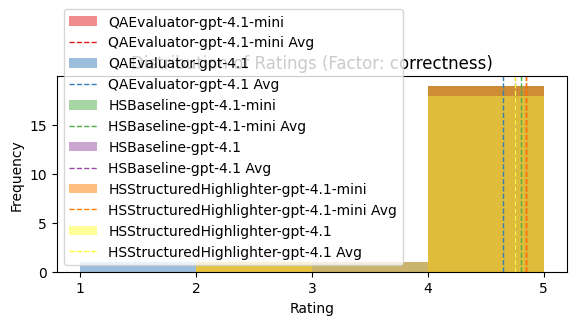

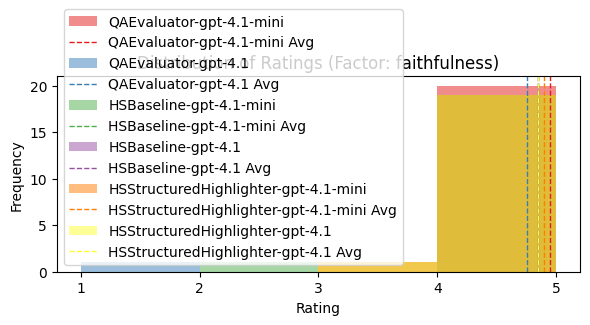

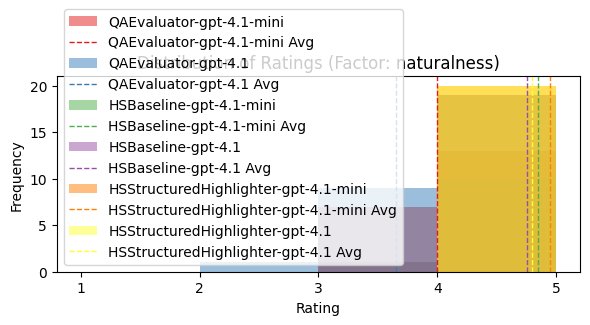

In [57]:
judge_name = "MT-bench-QA"
for factor in ["correctness", "faithfulness", "naturalness"]:
    plt.figure(figsize=(6, 3))
    colors = sns.color_palette("Set1", n_colors=len(ratings))
    for model_name in ratings:
        model_ratings = ratings[model_name]
        # if "HS" in model_name:
        #     continue
        # if not "mini" in model_name:
        #     continue
        color = colors.pop(0)
        judge_ratings = model_ratings[f"{judge_name}_{factor}"]
        plt.hist(judge_ratings, alpha=0.5, label=f"{model_name}", color=color, density=False, bins=np.arange(MIN_RATING, MAX_RATING + 1, 1))
        # A vertical line for each model's average rating.
        avg_rating = np.mean(judge_ratings)
        plt.axvline(avg_rating, linestyle='--', linewidth=1, label=f"{model_name} Avg", color=color)

    plt.xlabel("Rating")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Ratings (Factor: {factor})")
    plt.xticks(np.arange(MIN_RATING, MAX_RATING + 1, 1))
    plt.legend()
    plt.tight_layout()

#### Unanswerable

Loading: True
Loading: True
Loading: True
Loading: True
Loading: True
Loading: True
Loading: True
Loading: True
Loading: True


Loading: True
Loading: True
Loading: True


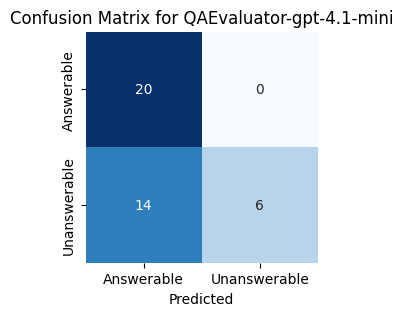

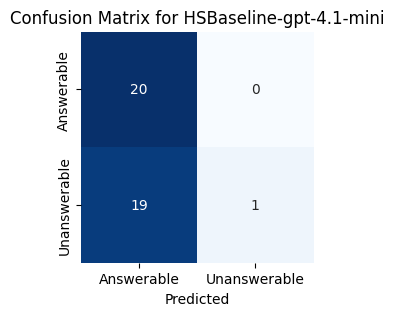

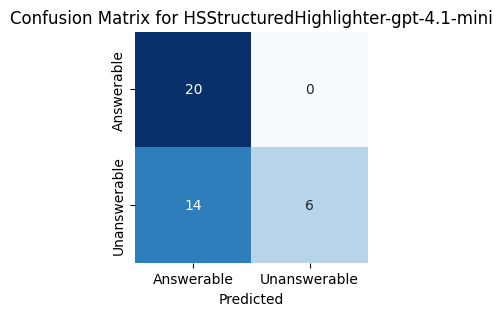

In [43]:
# Confusion matrix for (answer is answerable/unanswerable, answer_pred is answerable/unanswerable)
for model_name in inference_datasets:
    if not "mini" in model_name:
        continue
    answerable = inference_datasets[model_name].filter(
        lambda example: example["answer"] != NOANSWER_PRED
    )
    unanswerable = inference_datasets[model_name].filter(
        lambda example: example["answer"] == NOANSWER_PRED
    )
    answerable_correct = len(answerable.filter(lambda example: example["answer_pred"] != NOANSWER_PRED))
    unanswerable_correct = len(unanswerable.filter(lambda example: example["answer_pred"] == NOANSWER_PRED))

    # Plot as confusion matrix.
    confusion_matrix = np.array([[answerable_correct, len(answerable) - answerable_correct],
                                  [len(unanswerable) - unanswerable_correct, unanswerable_correct]])
    plt.figure(figsize=(3, 3))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Answerable", "Unanswerable"],
                yticklabels=["Answerable", "Unanswerable"])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted") 

#### Recall and K-F1

Referring to https://direct.mit.edu/tacl/article/doi/10.1162/tacl_a_00667/121196.

In [44]:
import tiktoken

enc = tiktoken.encoding_for_model("gpt-4")
encode = lambda x: len(enc.encode(x))

def ref_answer_recall(answer, answer_pred):
    """This metric measures the proportion of tokens in the
    reference `answer` that are present in the model response.
    """
    if answer == NOANSWER_PRED:
        raise ValueError("Reference answer is NOANSWER_PRED.")

    if answer_pred == NOANSWER_PRED:
        return 0.0
    
    answer_tokens = set(enc.encode(answer))
    answer_pred_tokens = set(enc.encode(answer_pred))
    common_tokens = answer_tokens.intersection(answer_pred_tokens)
    recall = len(common_tokens) / len(answer_tokens)
    return recall

def ref_passage_precision(passage, answer_pred):
    """This metric measures the proportion of tokens in the model
    response `answer_pred` that are present in the "gold passage" `passage`.
    """
    if answer_pred == NOANSWER_PRED:
        return 0.0
    
    passage_tokens = set(enc.encode(passage))
    answer_pred_tokens = set(enc.encode(answer_pred))
    common_tokens = passage_tokens.intersection(answer_pred_tokens)
    precision = len(common_tokens) / len(answer_pred_tokens)
    return precision

Model: QAEvaluator-gpt-4.1-mini
  Ref Answer Recall: 0.6697
  Ref Passage Precision: 0.8101
Model: HSBaseline-gpt-4.1-mini
  Ref Answer Recall: 0.7633
  Ref Passage Precision: 0.7268
Model: HSBaseline-gpt-4.1-mini-highlighter
  Ref Answer Recall: 0.7327
  Ref Passage Precision: 0.8795
Model: HSStructuredHighlighter-gpt-4.1-mini
  Ref Answer Recall: 0.8202
  Ref Passage Precision: 0.7334
Model: HSStructuredHighlighter-gpt-4.1-mini-highlighter
  Ref Answer Recall: 0.7909
  Ref Passage Precision: 0.8879


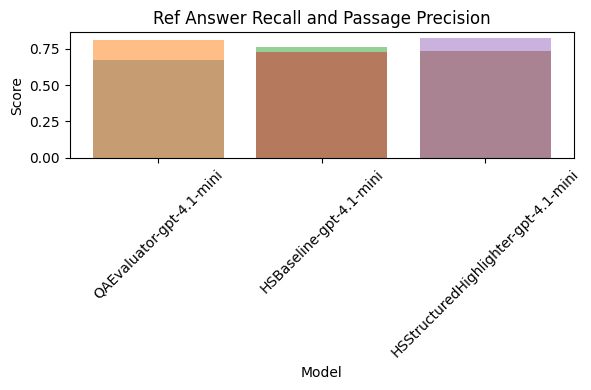

In [ ]:
results = {}
for model_name, dataset in inference_datasets.items():
    if not "mini" in model_name:
        continue
    results[model_name] = {
        "ref_answer_recall": [],
        "ref_passage_precision": [],
        "answer_length": [],
        "answer_pred_length": []
    }
    for example in dataset:
        # We skip unanswerable questions.
        if example["answer"] == NOANSWER_PRED:
            continue
        results[model_name]["ref_answer_recall"].append(
            ref_answer_recall(example["answer"], example["answer_pred"])
        )
        results[model_name]["ref_passage_precision"].append(
            ref_passage_precision(example["long_answer"], example["answer_pred"])
        )
    print(f"Model: {model_name}")
    print(f"  Ref Answer Recall: {np.mean(results[model_name]['ref_answer_recall']):.4f}")
    print(f"  Ref Passage Precision: {np.mean(results[model_name]['ref_passage_precision']):.4f}")

    # We also evaluate just the highlighter (i.e., no summarizer) for HS pipelines.
    if "HS" in model_name:
        results[f"{model_name}-highlighter"] = {
            "ref_answer_recall": [],
            "ref_passage_precision": [],
            "answer_length": [],
            "answer_pred_length": []
        }
        for example in dataset:
            if example["answer"] == NOANSWER_PRED:
                continue
            results[f"{model_name}-highlighter"]["ref_answer_recall"].append(
                ref_answer_recall(example["answer"], example["highlighter_extracted"])
            )
            results[f"{model_name}-highlighter"]["ref_passage_precision"].append(
                ref_passage_precision(example["long_answer"], example["highlighter_extracted"])
            )
        print(f"Model: {model_name}-highlighter")
        print(f"  Ref Answer Recall: {np.mean(results[f'{model_name}-highlighter']['ref_answer_recall']):.4f}")
        print(f"  Ref Passage Precision: {np.mean(results[f'{model_name}-highlighter']['ref_passage_precision']):.4f}")

# Plot the results as a bar chart.
plt.figure(figsize=(6, 4))
for model_name, result in results.items():
    if not "mini" in model_name:
        continue
    if "highlighter" in model_name:
        # Skip highlighter-only models for this plot.
        continue
    plt.bar(model_name, np.mean(result["ref_answer_recall"]), label=f"{model_name} Recall", alpha=0.5)
    plt.bar(model_name, np.mean(result["ref_passage_precision"]), label=f"{model_name} Precision", alpha=0.5)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Ref Answer Recall and Passage Precision")
plt.xticks(rotation=45)
# plt.legend()
plt.tight_layout()